Purpose of this notebook:

1. Enable quick manual segmentation of large TIF images containing multiple tiles in x-y and multiple z-planes, in a single channel
2. Create a table of cells X ROIs also containing information about the location of the cell in vivo (within a particular FOV)
3. Allow each cell to have ROIs in multiple z planes
4. Work with single image stitched in x-y if possible
5. Use ROIs from one channel to calculate intensity in other channels and produce histogram

# Setup

In [19]:
!conda install ipykernel --name py365

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.4.6
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda




In [4]:
!python -m ipykernel install

Installed kernelspec python3 in C:\ProgramData\jupyter\kernels\python3


In [1]:
%gui qt5 

In [2]:
# Imports in alphabetical order of module name

from PIL import Image, ImageDraw
import napari
import numpy as np
import pickle as pkl
import matplotlib.path as mpltpath
import matplotlib.pyplot as plt


# Load images

In [3]:
## Specify images to load

folder = 'Z:\HCR\9.2_FISH\S6_488_647_dapi_546_z-stack_tiles_2019_09_14__00_22_08'
base_filename = 'S6_488_647_dapi_546_z-stack_tiles_2019_09_14__00_22_08_z'
plane_nos = range(1, 30)
n = len(plane_nos)
print('Number of planes: {0}'.format(n))

Number of planes: 29


In [4]:
# Create 4D array to store images
img = Image.open('{0}\{1}{2}_ChS1-T1_ORG.tif'.format(folder, base_filename, str(plane_nos[0]).zfill(2)))
h = img.height
w = img.width
# c = np.array(img).shape[2]
# im_array = np.zeros([n, h, w, c])
print('Size of image in pixels: {0} X {1} X {2}'.format(n, h, w))

# for i in range(n):
#     print('Loading image {0}'.format(i + 1))
#     p = plane_nos[i]
#     img = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder, base_filename,str(p).zfill(2)))
#     try:
#         im_array[i, :, :, :] = np.array(img)
#     except:
#         print('Plane {0} could not be loaded'.format(p))
#         print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
#         im_array = np.delete(im_array, i, axis = 0)
#         plane_nos.remove(p)
#         i -= 1
#         n = len(plane_nos)
#         continue


FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\HCR\\9.2_FISH\\S6_488_647_dapi_546_z-stack_tiles_2019_09_14__00_22_08\\S6_488_647_dapi_546_z-stack_tiles_2019_09_14__00_22_08_z01_ChS1-T1_ORG.tif'

In [9]:
im_array_tac2 = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c1_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        im_array_tac2[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_tac2 = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29


In [11]:
im_array_npy2r = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c4_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        im_array_npy2r[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_npy2r = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29


In [37]:
len(plane_nos)

29

In [39]:
del im_array

# Annotation

## Data structure to store information about cells

In [ ]:
class Cell:
    n_cells = 1
    
    def __init__(self, cell_no):
        
        self.cell_no = cell_no
        self.z_planes = []
        self.no_planes = 0
        self.masks = {}
        self.c_vals = np.zeros(c)
        print('Cell #{0} created'.format(Cell.n_cells))
        Cell.n_cells += 1
        
    def add_mask(self, z_plane, mask):
        self.z_planes.append(z_plane)
        self.no_planes += 1
        self.masks[z_plane] = mask
            
    def save_cell(self):
        cell_data[self.cell_no] = {'cell_id': self.cell_no,
                                 'z_planes': self.z_planes,
                                 'masks': self.masks,
                                 'no_planes': self.no_planes,
                                 'c_vals':self.c_vals}
    
    def del_cell(self):
        Cell.n_cells -= 1

In [ ]:
save_loc = 'Z:\HCR\9.2_FISH'
save_file = 'S6_data.pkl'
cell_data = {}

## Render image in napari GUI

In [43]:
# Open image in napari viewer - each channel as a separate layer 
viewer = napari.Viewer()

for i in range(c):
    viewer.add_image(im_array[:, :, :, i], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
seg_channel = 1
viewer.add_shapes([], name = 'masks', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# Keybinding functions

@viewer.bind_key('n')
def new_cell(viewer):
    global cell1 
    cell1 = Cell(Cell.n_cells)

@viewer.bind_key('m')
def add_mask(viewer):
    seg_layer = viewer.layers[seg_channel]
    z_plane = seg_layer.coordinates[0]
    mask = viewer.layers['masks'].data[-1]
    cell1.add_mask(Cell.n_cells, z_plane, mask)
    
@viewer.bind_key('s')
def save_cell(viewer):
    cell1.save_cell()

C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])


## Manual segmentation

In [44]:
Cell.n_cells

1

In [703]:
if Cell.n_cells > 1:
    cell1.save_cell()
    print('Cell {0} saved'.format(cell1.cell_no))
cell1 = Cell(Cell.n_cells)

Cell 200 saved
Cell #201 created


In [702]:
seg_layer = viewer.layers[seg_channel]
z_plane = seg_layer.coordinates[0]

mask = viewer.layers['masks'].data[-1]
cell1.add_mask(z_plane, mask)
print('mask {0} added in z-plane {1} for cell {2}'.format(cell1.no_planes, z_plane, cell1.cell_no))
print(mask[0, :])

mask 2 added in z-plane 7 for cell 200
[2331.64752651  417.27423387]


In [704]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
    pkl.dump(cell_data, f)

In [14]:
with open('{0}\{1}'.format(save_loc, save_file), 'rb') as f:
    cell_data = pkl.load(f)

In [26]:
cell_data

{1: {'cell_id': 1,
  'z_planes': [0, 1],
  'masks': {0: array([[2953.8554176 ,  169.42836987],
          [2951.05161622,  180.02050843],
          [2957.28228596,  187.80884561],
          [2963.82448919,  188.1203791 ],
          [2968.4974915 ,  184.69351074],
          [2970.67822591,  180.02050843],
          [2966.93982406,  174.41290567],
          [2962.26682176,  170.05143685]]),
   1: array([[2949.1824153 ,  169.73990336],
          [2949.1824153 ,  178.15130751],
          [2951.05161622,  184.38197725],
          [2956.65921899,  187.49731212],
          [2960.70915432,  187.80884561],
          [2964.75908965,  187.80884561],
          [2966.62829058,  185.31657771],
          [2968.80902498,  180.95510889],
          [2966.93982406,  175.65903961],
          [2962.57835524,  173.16677172],
          [2956.97075248,  169.73990336]])},
  'no_planes': 2,
  'c_vals': array([0., 0., 0.])},
 2: {'cell_id': 2,
  'z_planes': [0],
  'masks': {0: array([[2858.52617056,  122.38681332

# Calculate intensity in other channels

In [12]:
# Only run once:
xv = range(w)
yv = range(h)
coord_array = np.array(np.meshgrid(xv, yv))

points = np.zeros([h*w, 2])
p = 0
for i in range(h):
    if np.mod(i, 100) == 0:
        print('Row {0}'.format(i))
    for j in range(w):
        points[p, 1] = coord_array[0, i, j]
        points[p, 0] = coord_array[1, i, j]
        p += 1

In [16]:
no_cells = len(cell_data.keys())
tac2_avg_intensity = np.zeros(no_cells)
npy2r_avg_intensity = np.zeros(no_cells)

for cell in range(no_cells):
    
    if np.mod(cell, 10) == 0:
        print('Cell {0}'.format(cell))
    cell_no = cell + 1
    cell_dict = cell_data[cell_no]
    masks = cell_dict['masks']
    z_planes = cell_dict['z_planes']

    tac2_intensity = np.zeros(cell_dict['no_planes'])
    npy2r_intensity = np.zeros(cell_dict['no_planes'])
    
    i = 0
    for plane in z_planes:

        vertices = masks[plane]
        path = mpltpath.Path(vertices)
        mask = path.contains_points(points)
        mask = np.reshape(mask, [h, w])

        tac2_intensity[i] = np.mean(im_array_tac2[plane, mask])
        npy2r_intensity[i] = np.mean(im_array_npy2r[plane, mask])
        i += 1
    
    tac2_avg_intensity[cell] = np.mean(tac2_intensity)
    npy2r_avg_intensity[cell] = np.mean(npy2r_intensity)


Cell 0
Cell 10
Cell 20
Cell 30
Cell 40
Cell 50
Cell 60
Cell 70
Cell 80
Cell 90
Cell 100
Cell 110
Cell 120
Cell 130
Cell 140
Cell 150
Cell 160
Cell 170
Cell 180
Cell 190


In [713]:
with open('{0}\{1}'.format(save_loc, 'S6_channel0_intensities.pkl'), 'wb') as f:
    pkl.dump({'avg_intensity_napari': avg_intensity, 
             'avg_intensity_raw': avg_intensity2}, f)

In [17]:
with open('{0}\{1}'.format(save_loc, 'S6_intensities.pkl'), 'wb') as f:
    pkl.dump({'tac2_avg_intensity': tac2_avg_intensity, 
             'npy2r_avg_intensity': npy2r_avg_intensity}, f)

(array([ 6., 11., 10., 12., 13., 24., 22., 19., 14.,  7.,  5.,  3.,  3.,
         4.,  2.,  6.,  4.,  3.,  1.,  4.,  5.,  0.,  2.,  1.,  0.,  3.,
         2.,  2.,  1.,  1.,  2.,  1.,  1.,  0.,  1.,  0.,  2.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.22841587, 0.24384756, 0.25927924, 0.27471092, 0.2901426 ,
        0.30557429, 0.32100597, 0.33643765, 0.35186933, 0.36730102,
        0.3827327 , 0.39816438, 0.41359606, 0.42902775, 0.44445943,
        0.45989111, 0.47532279, 0.49075448, 0.50618616, 0.52161784,
        0.53704952, 0.55248121, 0.56791289, 0.58334457, 0.59877625,
        0.61420794, 0.62963962, 0.6450713 , 0.66050298, 0.67593467,
        0.69136635, 0.70679803, 0.72222971, 0.7376614 , 0.75309308,
        0.76852476, 0.78395644, 0.79938813, 0.81481981, 0.83025149,
        0.84568317, 0.86111486, 0.87654654, 0.89197822, 0.9074099 ,
        0.92284159, 0.93827327, 0.95370495, 0.96913663, 0.98456832,
        1.        ]),
 <a list of 50

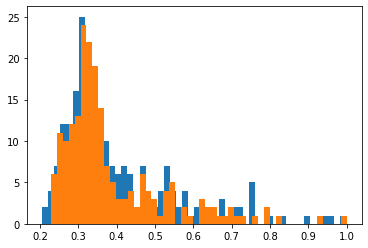

In [17]:
plt.hist(tac2_avg_intensity/np.nanmax(tac2_avg_intensity), 50)
plt.hist(npy2r_avg_intensity/np.nanmax(npy2r_avg_intensity), 50)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


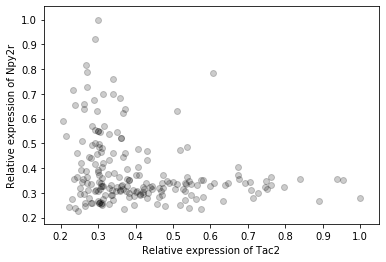

In [19]:
plt.scatter(tac2_avg_intensity/np.max(tac2_avg_intensity), npy2r_avg_intensity/np.max(npy2r_avg_intensity), color = 'k', 
            marker = 'o', alpha = 0.2)


plt.xlabel('Relative expression of Tac2')
plt.ylabel('Relative expression of Npy2r')
plt.savefig('C:\\Users\\singha\\Documents\\Janelia admin stuff\\2019_hopkins_poster\\vip_dist.eps')